In [38]:
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dropout, Flatten, Dense, Embedding, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_recall_curve

import numpy as np
from itertools import islice
from keras.constraints import max_norm, unit_norm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

In [2]:
vocab_size = 10000
maxlen = 300
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = vocab_size) 

In [3]:
x_train = pad_sequences(x_train, maxlen = maxlen, padding = 'pre')
x_test =  pad_sequences(x_test, maxlen = maxlen, padding = 'pre')

In [4]:
X = np.concatenate((x_train, x_test), axis = 0)
y = np.concatenate((y_train, y_test), axis = 0)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state, shuffle = True)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, random_state = random_state, shuffle = True)

In [6]:
print('---'*20, f'\nrows in training dataset: {x_train.shape[0]}')
print(f'columns in training dataset: {x_train.shape[1]}')
print(f'unique words in training dataset: {len(np.unique(np.hstack(x_train)))}')


print('---'*20, f'\nrows in validation dataset: {x_valid.shape[0]}')
print(f'columns in validation dataset: {x_valid.shape[1]}')
print(f'unique words in validation dataset: {len(np.unique(np.hstack(x_valid)))}')


print('---'*20, f'\nrows in test dataset: {x_test.shape[0]}')
print(f'columns in test dataset: {x_test.shape[1]}')
print(f'unique words in test dataset: {len(np.unique(np.hstack(x_test)))}')


print('---'*20, f'\nUnique Categories: {np.unique(y_train), np.unique(y_valid), np.unique(y_test)}')

------------------------------------------------------------ 
rows in training dataset: 32000
columns in training dataset: 300
unique words in training dataset: 9999
------------------------------------------------------------ 
rows in validation dataset: 8000
columns in validation dataset: 300
unique words in validation dataset: 9984
------------------------------------------------------------ 
rows in test dataset: 10000
columns in test dataset: 300
unique words in test dataset: 9995
------------------------------------------------------------ 
Unique Categories: (array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64))


In [8]:
train_len = [len(sequence) for sequence in x_train]
test_len = [len(sequence) for sequence in x_test]
print('Maximum value of a word index:', max([max(sequence) for sequence in x_train]))
print('Maximum length num words of review in train:', max([len(sequence) for sequence in x_train]))

Maximum value of a word index: 9999
Maximum length num words of review in train: 300


In [9]:
unique, counts = np.unique(np.concatenate((y_train, y_test)), return_counts=True)
sentiments = {1: 'Positive', 0: 'Negative'}

def interprete_review(sequence):
    id_to_word = dict([(value, key) for (key, value) in imdb.get_word_index().items()])
    decoded_review = ' '.join([id_to_word.get(idx-3, '?') for idx in sequence])
    print(decoded_review)
    
review_id1 = np.random.choice(train_len)
interprete_review(x_train[review_id1])
print('The sentiment for the above review is:', sentiments.get(y_train[review_id1]))
print('\n')
review_id2 = np.random.choice(test_len)
interprete_review(x_test[review_id2])
print('The sentiment for the above review is:', sentiments.get(y_test[review_id2]))

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? terrible just terrible probably the worst film i have ever seen and i did see some pretty bad pictures throughout the years the sound sucks so does the quality of the picture the direction the acting etc etc the only good shoots meaning funny because they're so bad are the special effects overall there are about 5 minutes worth of laughs the rest of the flick gives you brain damage
The sentiment for the above review is: Negative


? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?

In [20]:
embedding_dim = 300
# Build the network
ann = Sequential()
ann.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = maxlen))
ann.add(Flatten())
ann.add(Dense(1, activation = 'sigmoid'))
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
ann.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 300, 300)          3000000   
                                                                 
 flatten_2 (Flatten)         (None, 90000)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 90001     
                                                                 
Total params: 3090001 (11.79 MB)
Trainable params: 3090001 (11.79 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
epochs = 5
batches = 512
history = ann.fit(x_train, y_train, epochs = epochs, batch_size = batches, validation_split = 0.2)

Epoch 1/5
50/50 [==============================] - 11s 203ms/step - loss: 0.6235 - accuracy: 0.6572 - val_loss: 0.4489 - val_accuracy: 0.8252
Epoch 2/5
50/50 [==============================] - 12s 235ms/step - loss: 0.2931 - accuracy: 0.8912 - val_loss: 0.2874 - val_accuracy: 0.8803
Epoch 3/5
50/50 [==============================] - 8s 168ms/step - loss: 0.1658 - accuracy: 0.9470 - val_loss: 0.2702 - val_accuracy: 0.8863
Epoch 4/5
50/50 [==============================] - 9s 174ms/step - loss: 0.0978 - accuracy: 0.9787 - val_loss: 0.2685 - val_accuracy: 0.8888
Epoch 5/5
50/50 [==============================] - 9s 175ms/step - loss: 0.0560 - accuracy: 0.9927 - val_loss: 0.2743 - val_accuracy: 0.8886


In [22]:
tr_loss, tr_acc = ann.evaluate(x_train, y_train)
print('Training Loss: %.4f and Accuracy: %.2f%%' % (tr_loss, tr_acc * 100))

loss, acc = ann.evaluate(x_test, y_test)
print('Test Loss: %.4f and Accuracy: %.2f%%' % (loss, acc * 100))

1000/1000 [==============================] - 8s 8ms/step - loss: 0.0838 - accuracy: 0.9759
Training Loss: 0.0838 and Accuracy: 97.59%
313/313 [==============================] - 3s 8ms/step - loss: 0.2715 - accuracy: 0.8898
Test Loss: 0.2715 and Accuracy: 88.98%


313/313 [==============================] - 3s 8ms/step
Testing accuracy: 88.98

 Confusion matrix:
 [[4374  538]
 [ 564 4524]]


Text(0.5, 1.0, 'Confusion Matrix HeatMap')

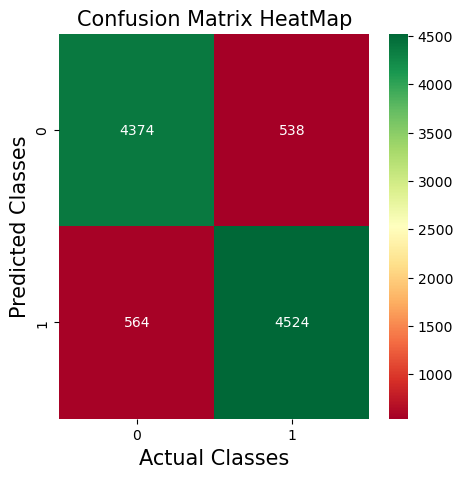

In [28]:
y_pred = (ann.predict(x_test) > 0.5).astype("int32")

print('Testing accuracy:', (accuracy_score(y_test, y_pred) * 100))

cfm_ann = confusion_matrix(y_test, y_pred)
print('\n Confusion matrix:\n', cfm_ann)

plt.figure(figsize = (5, 5))
sns.heatmap(cfm_ann, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.xlabel('Actual Classes', fontsize = 15)
plt.ylabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix HeatMap', fontsize = 15)

In [29]:
print('Classification report:\n', (classification_report(y_test, y_pred)))

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89      4912
           1       0.89      0.89      0.89      5088

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [39]:
lstm = Sequential()
lstm.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = maxlen))
lstm.add(Dropout(0.2))
lstm.add(LSTM(128, activation = 'tanh', dropout = 0.2,
               kernel_constraint = unit_norm(),
               recurrent_constraint = unit_norm(),
               bias_constraint = unit_norm()))
lstm.add(Dense(150, activation = 'relu')) 
lstm.add(Dropout(0.2))
lstm.add(Dense(1, activation = 'sigmoid'))
lstm.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 300, 300)          3000000   
                                                                 
 dropout_1 (Dropout)         (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense_3 (Dense)             (None, 150)               19350     
                                                                 
 dropout_2 (Dropout)         (None, 150)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 151       
                                                                 
Total params: 3239149 (12.36 MB)
Trainable params: 323

In [40]:
epochs = 5
batches = 128

history = lstm.fit(x_train, y_train, epochs = epochs, batch_size = batches, validation_split = 0.2) 

Epoch 1/5
200/200 [==============================] - 954s 5s/step - loss: 0.4469 - accuracy: 0.7795 - val_loss: 0.3215 - val_accuracy: 0.8647
Epoch 2/5
200/200 [==============================] - 1292s 6s/step - loss: 0.2595 - accuracy: 0.8979 - val_loss: 0.3160 - val_accuracy: 0.8687
Epoch 3/5
200/200 [==============================] - 1399s 7s/step - loss: 0.1900 - accuracy: 0.9286 - val_loss: 0.3258 - val_accuracy: 0.8662
Epoch 4/5
200/200 [==============================] - 1481s 7s/step - loss: 0.1451 - accuracy: 0.9468 - val_loss: 0.3722 - val_accuracy: 0.8728
Epoch 5/5
200/200 [==============================] - 1454s 7s/step - loss: 0.1248 - accuracy: 0.9556 - val_loss: 0.3923 - val_accuracy: 0.8622


In [41]:
tr_loss, tr_acc = lstm.evaluate(x_train, y_train)
print('Training Loss: %.4f and Accuracy: %.2f%%' % (tr_loss, tr_acc * 100))

loss, acc = lstm.evaluate(x_test, y_test)
print('Test Loss: %.4f and Accuracy: %.2f%%' % (loss, acc * 100))

1000/1000 [==============================] - 163s 162ms/step - loss: 0.1541 - accuracy: 0.9508
Training Loss: 0.1541 and Accuracy: 95.08%
313/313 [==============================] - 51s 162ms/step - loss: 0.3707 - accuracy: 0.8615
Test Loss: 0.3707 and Accuracy: 86.15%


Sentiment classification task on the IMDB dataset, on test dataset,
Accuracy: > 89%
F1-score: > 89%
Loss of 0.25
